airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9

In [2]:
import os
import sys
import gc

import time
import json
import random
import math
import numpy as np

import torch

from torch.optim.adamw import AdamW
from torch.nn.utils import clip_grad_norm_
import torch.distributed as dist
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import save_image


from wolf.data import load_datasets, get_batch, preprocess, postprocess
from wolf import WolfModel
from wolf.utils import total_grad_norm
from wolf.optim import ExponentialScheduler

from experiments.options import parse_args

from matplotlib import pyplot as plt

from tqdm import tqdm_notebook

import autoreload
%load_ext autoreload
%autoreload 2

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
print(torch.cuda.current_device())

1


In [4]:
torch.cuda.set_device(1)

In [6]:
def is_master(rank):
    return rank <= 0


def is_distributed(rank):
    return rank >= 0

def logging(info, logfile=None):
    print(info)
    if logfile is not None:
        print(info, file=logfile)
        logfile.flush()

In [7]:
def init_dataloader(args, train_data, val_data):
    if is_distributed(args.rank):
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_data, rank=args.rank,
                                                                        num_replicas=args.world_size,
                                                                        shuffle=True)
    else:
        train_sampler = None
    train_loader = DataLoader(train_data, batch_size=args.batch_size,
                              shuffle=(train_sampler is None), sampler=train_sampler,
                              num_workers=args.workers, pin_memory=True, drop_last=True)
    if is_master(args.rank):
        eval_batch = args.eval_batch_size
        val_loader = DataLoader(val_data, batch_size=eval_batch, shuffle=False,
                                num_workers=args.workers, pin_memory=True)
    else:
        val_loader = None

    return train_loader, train_sampler, val_loader

In [8]:
def setup(args):
    def check_dataset():
        if dataset == 'cifar10':
            assert image_size == 32, 'CIFAR-10 expected image size 32 but got {}'.format(image_size)
        elif dataset.startswith('lsun'):
            assert image_size in [128, 256]
        elif dataset == 'celeba':
            assert image_size in [256, 512]
        elif dataset == 'imagenet':
            assert image_size in [64, 128, 256]

    dataset = args.dataset
    if args.category is not None:
        dataset = dataset + '_' + args.category
    image_size = args.image_size
    check_dataset()

    nc = 3
    args.nx = image_size ** 2 * nc
    n_bits = args.n_bits
    args.n_bins = 2. ** n_bits
    args.test_k = 1

    model_path = args.model_path
    args.checkpoint_name = os.path.join(model_path, 'checkpoint')

    result_path = os.path.join(model_path, 'images')
    args.result_path = result_path
    data_path = args.data_path

    if is_master(args.rank):
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        if args.recover < 0:
            args.log = open(os.path.join(model_path, 'log.txt'), 'w')
        else:
            args.log = open(os.path.join(model_path, 'log.txt'), 'a')
    else:
        args.log = None

    args.cuda = torch.cuda.is_available()
    random_seed = args.seed + args.rank if args.rank >= 0 else args.seed
    if args.recover >= 0:
        random_seed += random.randint(0, 1024)
    logging("Rank {}: random seed={}".format(args.rank, random_seed), logfile=args.log)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    device = torch.device('cuda', args.local_rank) if args.cuda else torch.device('cpu')
    if args.cuda:
        torch.cuda.set_device(device)
        torch.cuda.manual_seed(random_seed)

    torch.backends.cudnn.benchmark = True

    args.world_size = int(os.environ["WORLD_SIZE"]) if is_distributed(args.rank) else 1
    logging("Rank {}: ".format(args.rank) + str(args), args.log)

    train_data, val_data = load_datasets(dataset, image_size, data_path=data_path)
    train_index = np.arange(len(train_data))
    np.random.shuffle(train_index)
    val_index = np.arange(len(val_data))

    if is_master(args.rank):
        logging('Data size: training: {}, val: {}'.format(len(train_index), len(val_index)))

    if args.recover >= 0:
        params = json.load(open(os.path.join(model_path, 'config.json'), 'r'))
    else:
        params = json.load(open(args.config, 'r'))
        json.dump(params, open(os.path.join(model_path, 'config.json'), 'w'), indent=2)

    wolf = WolfModel.from_params(params)
    wolf.to_device(device)
    args.device = device
    
    if args.recover >= 0:
        wolf = WolfModel.load(args.model_path, args.device, 0)

    return args, (train_data, val_data), (train_index, val_index), wolf

In [9]:
debug=False

def eval(args, val_loader, wolf):
    wolf.eval()
    wolf.sync()
    gnll = 0
    nent = 0
    kl = 0
    num_insts = 0
    device = args.device
    n_bits = args.n_bits
    n_bins = args.n_bins
    nx = args.nx
    test_k = args.test_k
    
    results = []

    for step, (data, y) in enumerate(val_loader):
        batch_size = len(data)
        data = data.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.no_grad():
            wolf.loss(data, y=y, n_bits=n_bits, nsamples=test_k)
#         print('shape is ', attns.shape)
        
#         del attns
#         gc.collect()
#         size_bool = True
#         for attn_idx in range(len(attns_)-1):
#             size_bool = (size_bool and (attns_[attn_idx].shape == attns_[attn_idx].shape))
#         if debug:
#             if size_bool:
#                 print('the length of attentions is {}; the shape of attention is {}'.format(len(attns_), attns_[0].shape))
#             else:
#                 print('Size not matched')
#         gnll += loss_gen.sum().item()
#         kl += loss_kl.sum().item()
#         nent += loss_dequant.sum().item()
#         num_insts += batch_size
        
#         results.append((data.to('cpu'), y.to('cpu'), attns.to('cpu')))
        results.append((data.to('cpu'), y.to('cpu')))
        
        if step % 10 == 0:
            print('Step: ', step)
            torch.cuda.empty_cache()

#     gnll = gnll / num_insts
#     nent = nent / num_insts
#     kl = kl / num_insts
#     nll = gnll + kl + nent + np.log(n_bins / 2.) * nx
#     bpd = nll / (nx * np.log(2.0))
#     nepd = nent / (nx * np.log(2.0))
#     logging('Avg  NLL: {:.2f}, KL: {:.2f}, NENT: {:.2f}, BPD: {:.4f}, NEPD: {:.4f}'.format(
#         nll, kl, nent, bpd, nepd), args.log)
    return results

In [10]:
def main(args):
    args, (train_data, val_data), (train_index, val_index), wolf = setup(args)

    train_loader, train_sampler, val_loader = init_dataloader(args, train_data, val_data)

    return eval(args, val_loader, wolf), wolf

In [11]:
args_dict = {'rank': -1,
 'local_rank': 0,
 'config': 'experiments/configs/cifar10/glow/glow-cat-uni.json',
 'batch_size': 256,
 'eval_batch_size': 512,
 'batch_steps': 2,
 'init_batch_size': 1024,
 'epochs': 100,
 'valid_epochs': 10,
 'seed': 65537,
 'train_k': 1,
 'log_interval': 10,
 'lr': 0.001,
 'warmup_steps': 50,
 'lr_decay': 0.999997,
 'beta1': 0.9,
 'beta2': 0.999,
 'eps': 1e-08,
 'weight_decay': 1e-06,
 'amsgrad': False,
 'grad_clip': 0.0,
 'dataset': 'cifar10',
 'category': None,
 'image_size': 32,
 'workers': 4,
 'n_bits': 8,
 'model_path': 'experiments/models/glow/cifar_linear_model/',
 'data_path': 'experiments/data/cifar_data',
 'recover': 1,
}

from argparse import Namespace

args = Namespace(**args_dict)

In [12]:
results, wolf = main(args)

Rank -1: random seed=66096
Rank -1: Namespace(amsgrad=False, batch_size=256, batch_steps=2, beta1=0.9, beta2=0.999, category=None, checkpoint_name='experiments/models/glow/cifar_linear_model/checkpoint', config='experiments/configs/cifar10/glow/glow-cat-uni.json', cuda=True, data_path='experiments/data/cifar_data', dataset='cifar10', epochs=100, eps=1e-08, eval_batch_size=512, grad_clip=0.0, image_size=32, init_batch_size=1024, local_rank=0, log=<_io.TextIOWrapper name='experiments/models/glow/cifar_linear_model/log.txt' mode='a' encoding='UTF-8'>, log_interval=10, lr=0.001, lr_decay=0.999997, model_path='experiments/models/glow/cifar_linear_model/', n_bins=256.0, n_bits=8, nx=3072, rank=-1, recover=1, result_path='experiments/models/glow/cifar_linear_model/images', seed=65537, test_k=1, train_k=1, valid_epochs=10, warmup_steps=50, weight_decay=1e-06, workers=4, world_size=1)
Files already downloaded and verified
Data size: training: 50000, val: 10000


FileNotFoundError: [Errno 2] No such file or directory: 'experiments/models/glow/cifar_linear_model/config.json'

In [9]:
def reconstruct(args, img, y1, y2, wolf):
    print('reconstruct')
    wolf.eval()
    batch = 1
    nsamples = 15

#     index = np.arange(len(data))
#     np.random.shuffle(index)
#     img, y = get_batch(data, index[:batch])
    img = img.to(args.device)
    y1 = y1.to(args.device)
    y2 = y2.to(args.device)
    
    with torch.no_grad():
        image_size = (3, args.image_size, args.image_size)
        _, epsilon1 = wolf.encode(img, y=y1, n_bits=args.n_bits, nsamples=nsamples, random=True)
        epsilon1 = epsilon1.view(batch * nsamples, *image_size)
        z1 = wolf.encode_global(img, y=y1, n_bits=args.n_bits, nsamples=nsamples, random=True)
        z1 = z1.view(batch * nsamples, z1.size(2))
        # [batch, nsamples, c, h, w]
        img_recon1 = wolf.decode(epsilon1, z=z1, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        
        _, epsilon2 = wolf.encode(img, y=y2, n_bits=args.n_bits, nsamples=nsamples, random=True)
        epsilon2 = epsilon2.view(batch * nsamples, *image_size)
        z2 = wolf.encode_global(img, y=y2, n_bits=args.n_bits, nsamples=nsamples, random=True)
        z2 = z2.view(batch * nsamples, z2.size(2))
        # [batch, nsamples, c, h, w]
        img_recon2 = wolf.decode(epsilon2, z=z2, n_bits=args.n_bits).view(batch, nsamples, *image_size)
        
        # [batch, 1, c, h, w]
        img = postprocess(preprocess(img, args.n_bits), args.n_bits).unsqueeze(1)
    
    fig, axs = plt.subplots(1,3)
    img_cpu = img.cpu()
    img_recon1_cpu = img_recon1.cpu()
    img_recon2_cpu = img_recon2.cpu()

    axs[0].imshow(img_cpu[0][0].permute(1, 2, 0))
    axs[1].imshow(img_recon1_cpu[0][0].permute(1, 2, 0))
    axs[2].imshow(img_recon2_cpu[0][0].permute(1, 2, 0))
    print('Recon1 and Origin: ', torch.norm(img_recon1_cpu[0][0] - img_cpu[0][0]))
    print('Recon2 and Origin: ', torch.norm(img_recon2_cpu[0][0] - img_cpu[0][0]))
    print('Recon1 and Recons: ', torch.norm(img_recon1_cpu[0][0] - img_recon2_cpu[0][0]))
    print('eps shape: ', epsilon1.shape)
    print('z shape: ', z1.shape)
    print('z1 and z2: ', torch.norm(z1 - z2))
    print('eps1 and eps2: ', torch.norm(epsilon1 - epsilon2))

    # [batch, nsamples + 1, c, h, w] -> [batch*(nsamples + 1), c, h, w]
#     comparison = torch.cat([img, img_recon], dim=1).view(-1, *image_size).cpu()

reconstruct
torch.Size([1, 15, 64])
torch.Size([1, 15, 64])
torch.Size([1, 15, 64])
torch.Size([1, 15, 64])
Recon1 and Origin:  tensor(0.)
Recon2 and Origin:  tensor(0.0068)
Recon1 and Recons:  tensor(0.0068)
eps shape:  torch.Size([15, 3, 32, 32])
z shape:  torch.Size([15, 64])
z1 and z2:  tensor(7.4758, device='cuda:0')
eps1 and eps2:  tensor(84.9050, device='cuda:0')


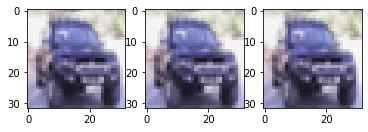

In [10]:
data_1, label_1 = results[0]
y_1_ = results[0][1]
reconstruct(args, data_1[9].unsqueeze(0), label_1[0].unsqueeze(0), label_1[2].unsqueeze(0), wolf)

In [11]:
label_1[0]

tensor(3)

In [12]:
def sample(args, epoch, wolf):
    logging('sampling', args.log)
    wolf.eval()
    n = 64 if args.image_size > 128 else 256
    nrow = int(math.sqrt(n))
    taus = [0.7, 0.8, 0.9, 1.0]
    start_time = time.time()
    image_size = (3, args.image_size, args.image_size)
    for t in taus:
        imgs = wolf.synthesize(n, image_size, tau=t, n_bits=args.n_bits, device=args.device)
#         plt.imshow(imgs)
        image_file = 'sample{}.t{:.1f}.png'.format(epoch, t)
        save_image(imgs, os.path.join(args.result_path, image_file), nrow=nrow)
    logging('time: {:.1f}s'.format(time.time() - start_time), args.log)

In [13]:
with torch.no_grad():
    sample(args, 222, wolf)

sampling
time: 4.3s


In [30]:
def synthesize_cat(args, epoch, wolf, label):
    logging('sampling based on cat', args.log)
    wolf.eval()
    n = 64 if args.image_size > 128 else 256
    nrow = int(math.sqrt(n))
    taus = [0.7, 0.8, 0.9, 1.0]
    image_size = (3, args.image_size, args.image_size)
    device = args.device
#     label = torch.Tensor(label).to(device).long()
    label = label.to(device)
    print(label)
    
    for t in taus:
        epsilon = torch.randn(n, *image_size, device=device)
        epsilon = epsilon * t
        z = wolf.encode_global(epsilon, label)
        z = z.view(n, z.size(2))
        imgs = wolf.decode(epsilon, z)
        image_file = 'sample{}.t{:.1f}.png'.format(epoch, t)
        save_image(imgs, os.path.join(args.result_path, image_file), nrow=nrow)

In [42]:
with torch.no_grad():
    synthesize_cat(args, 224, wolf, label_1[6].unsqueeze(0))

sampling based on cat
tensor([1], device='cuda:0')
torch.Size([256, 1, 64])
torch.Size([256, 1, 64])
torch.Size([256, 1, 64])
torch.Size([256, 1, 64])


In [32]:
label_1[0]

tensor(3)

In [41]:
label_1[6]

tensor(1)

In [18]:
wolf.core.discriminator

CategoricalDiscriminator(
  (embed): Embedding(10, 64)
  (net): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=256, out_features=64, bias=True)
  )
)